Paquetes necesarios

In [2]:
import cv2  
import numpy as np
import matplotlib.pyplot as plt
import csv

#Identificación de monedas

Carga imagen y convierte a RGB

(938, 473, 3)


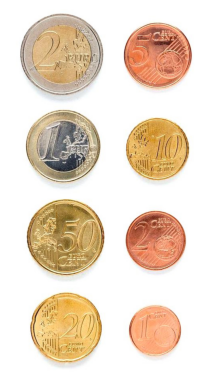

In [2]:
#Carga imagen ejemplo con monedas
img = cv2.imread('Monedas.jpg') 
print(img.shape)
#Recordar que OpenCV lee las imágenes en BGR, por lo que convertimos para visualizr a RGB
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.axis("off")
plt.imshow(img_rgb) 
plt.show()

Convierte a gris y muestra histograma

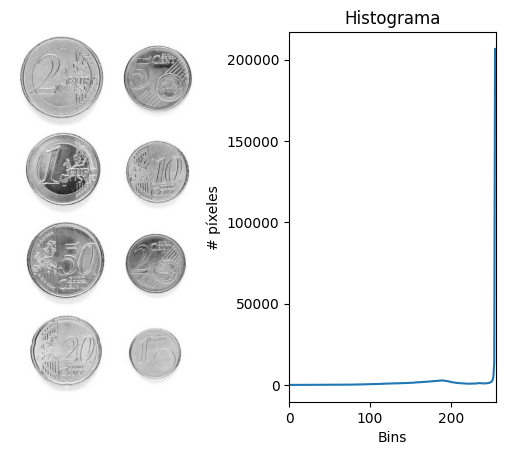

In [3]:
#Convierte la imagen a todos de gris, mostrando el resultado
img_gris = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

#Cálculo del histograma con 256 bins de una imagen en escala de grises
hist = cv2.calcHist([img_gris], [0], None, [256], [0, 256])

plt.figure()
plt.subplot(1, 2, 1)
plt.axis("off")
plt.imshow(img_gris, cmap='gray')

# Histograma sin normalizar
plt.subplot(1, 2, 2)
plt.title("Histograma")
plt.xlabel("Bins")
plt.ylabel("# píxeles")
plt.plot(hist)
plt.xlim([0, 256])
# Separo subplots horizontalmente
plt.subplots_adjust(wspace=0.4)

Cuenta resultado tras umbralizar (poniendo a negro el fondo)

Umbral fijo usado  200.0
Umbral Otsu  204.0


Text(0.5, 1.0, 'OTSU invertida')

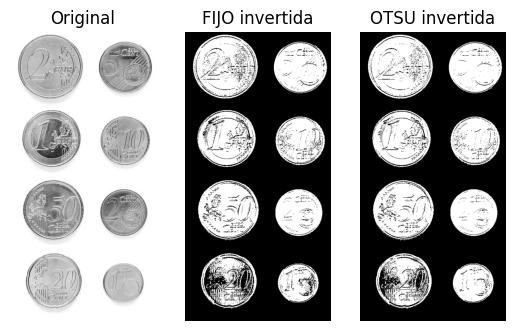

In [4]:
#Dos variantes de umbralizado. Probar otros parámetros, aplicar filtro previo, etc.
umbral = 200 # Prueba varios comenzando en 130
# Umbralizado binario invertido, dado que por defecto se asume objetos en blanco
th1,img_th1 = cv2.threshold(img_gris,umbral,255,cv2.THRESH_BINARY_INV)
print('Umbral fijo usado ', th1)
# Umbralizado con método de Otsu para selección automática del umbral
th2,img_th2 = cv2.threshold(img_gris,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
print('Umbral Otsu ', th2)

plt.subplot(1, 3, 1)
plt.axis("off")
plt.imshow(img_gris,cmap='gray') 
plt.title('Original')

plt.subplot(1, 3, 2)
plt.axis("off")
plt.imshow(img_th1,cmap='gray') 
plt.title('FIJO invertida')

plt.subplot(1, 3, 3)
plt.axis("off")
plt.imshow(img_th2,cmap='gray') 
plt.title('OTSU invertida')



Búsqueda de componentes y sus contornos

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


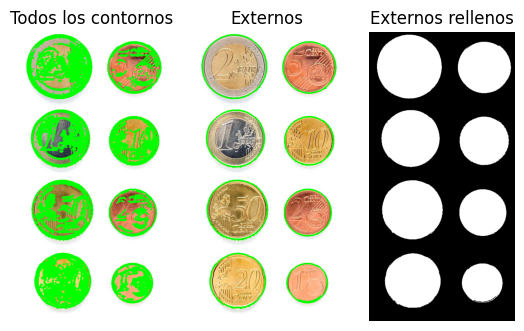

In [5]:
#Localiza contornos en imagen obtenida con umbral fijo
#findContours está diseñada para imágenes con  figura en blanco y fondo negro
#La imagen de entrada debe ser de un canal y 8 bits excepto en los modos RETR_CCOMP o RETR_FLOODFILL
#hierarchy contiene información sobre el nivel del contorno, relaciones paterno-filiales (contornos contenidos en otros)

#Obtiene todos los contornos: externos e internos
contornos, hierarchy = cv2.findContours(
    img_th1, #imagen
    cv2.RETR_TREE, #Modo de recuperación (lista, árbol, nivel superior)
    cv2.CHAIN_APPROX_SIMPLE #Método de aproximación del contorno
    )


#Dibuja sobre la imagen de entrada los contornos en verde
#Cada vez que quiere pintar convierte img para no tener restos
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
cv2.drawContours(img_rgb, contornos, -1, (0,255,0), 3)

plt.subplot(131)
plt.axis("off")
plt.imshow(img_rgb) 
plt.title('Todos los contornos')

#Obtiene únicamente los contornos externos
contornos2, hierarchy2 = cv2.findContours(img_th1, 
    cv2.RETR_EXTERNAL , 
    cv2.CHAIN_APPROX_SIMPLE)

#Dibuja sobre la imagen de entrada sólo contornos externos
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
cv2.drawContours(img_rgb, contornos2, -1, (0,255,0), 3)

plt.subplot(132)
plt.axis("off")
plt.imshow(img_rgb) 
plt.title('Externos')

#Dibuja contornos externos rellenos en imagen vacía
#Imagen negra
img_cont = np.zeros(img_rgb.shape)
#Recorre los contornos externos
for c in contornos2:
    #Área del contorno
    area = cv2.contourArea(c)
    #Área mínima (útil filtrar en ocasiones)
    if area > 10:
        #Perímetro del contorno
        perimetro = cv2.arcLength(c,True)
        #Contenedor alineado con ejes de la imagen
        x,y,w,h = cv2.boundingRect(c)
        #Mínimo contenedor ajustado para el contorno
        rect = cv2.minAreaRect(c)
        #Mínimo círculo que contiene al contorno
        (cx,cy),radio = cv2.minEnclosingCircle(c)
        #Elipse ajustada al contorno, exgigiendo un mínimo de puntos del contornos
        if c.shape[0] > 5:
            elipse = cv2.fitEllipse(c)
            #Para determinadas tareas nos puede interesará mostrar los valores obtenidos del contorno
            #print(area, perimetro, rect, cx,cy,radio, elipse)

        #Dibuja los contornos
        cv2.drawContours(img_cont, [c], -1, (255,255,255), -1)

plt.subplot(133)
plt.axis("off")
plt.imshow(img_cont) 
plt.title('Externos rellenos')
plt.show()


Alternativa contando círculos utilizando la Transformada de Hough. La selección de parámetros puede ser "divertida", más [información](https://docs.opencv.org/4.x/da/d53/tutorial_py_houghcircles.html)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


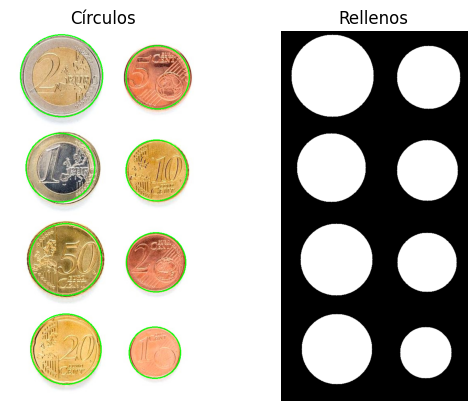

In [6]:
#Conversión a gris
gris = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#Suaviza imagen (elimina altas frecuencias)
pimg = cv2.medianBlur(gris, 7)
#Localiza Círculos
circ = cv2.HoughCircles(
        pimg,  # imagen 
        cv2.HOUGH_GRADIENT,  # tipo de detección
        1,
        100,  # distancia mínima entre círculos
        param1=100, # valor del gradiente
        param2=50, # umbral acumulador
        minRadius=50,  # radio mínimo
        maxRadius=150,  # radio máximo
    )
#Dibuja sobre entrada e imagen vacía
img_cont = np.zeros(img_rgb.shape)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
for det in circ[0]:
        x_coor, y_coor, det_radio = det
        cv2.circle(img_rgb,(int(x_coor), int(y_coor)),
            int(det_radio),(0, 255, 0), 2)
        cv2.circle(img_cont,(int(x_coor), int(y_coor)),
            int(det_radio),(255, 255, 255), -1)

#Muestra resultado
plt.subplot(121)
plt.axis("off")
plt.imshow(img_rgb) 
plt.title('Círculos')

plt.subplot(122)
plt.axis("off")
plt.imshow(img_cont) 
plt.title('Rellenos')

plt.show()

Las formas localizadas tienen distintas características geométricas, que pueden estimarse a partir de sus contornos. Más información en la [documentación de OpenCV](https://docs.opencv.org/4.x/dd/d49/tutorial_py_contour_features.html).

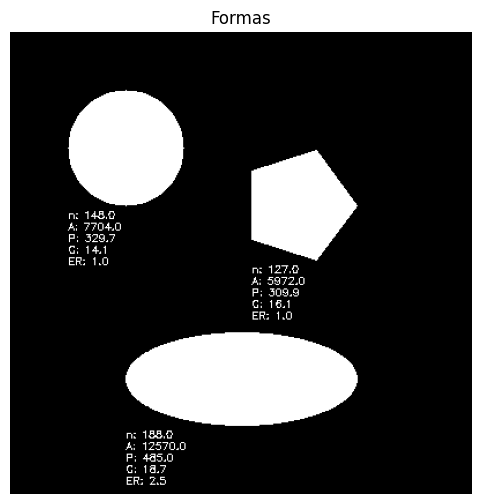

In [7]:
#Creación de polígono regular
def poligono_regular(image, ctr, radio, lados, color):
    pts = []
    ang_step = 2 * np.pi / lados
    for i in range(lados):
        ang = i * ang_step
        x = int(ctr[0] + radio * np.cos(ang))
        y = int(ctr[1] + radio * np.sin(ang))
        pts.append((x, y))
    pts = np.array(pts, np.int32)
    #regorganiza
    pts = pts.reshape((-1, 1, 2))
    cv2.fillPoly(image, [pts], color=color)

# Imagen vacía
img = np.zeros((400, 400, 1), dtype="uint8")
color = (255, 255, 255)

# Formas básicas
cv2.circle(img, (100, 100), 50, color, -1)  # Circular
poligono_regular(img, (250, 150), 50, 5, color)  # Polígono regular
cv2.ellipse(img, (200, 300), (100, 40), 0, 0, 360, color, -1)  # Elíptica

# Localiza contornos
contours, _ = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Parámeros texto
font = cv2.FONT_HERSHEY_SIMPLEX
font_scale = 0.3
thickness = 1

# Process each contour to calculate compactness and ellipse ratio (if possible)
for c in contours:
    # Puntos del contorno
    
    clon = len(c)
    # Área y perímetro
    area = cv2.contourArea(c)
    perimetro = cv2.arcLength(c, True)

    #Contenedor alineado con ejes de la imagen
    x,y,w,h = cv2.boundingRect(c)
    
    # Compactness: 4*pi*Area/Perimeter^2
    if perimetro > 0:
        compacidad = (perimetro ** 2) / area
    else:
        compactness = 0
    
    # Ajusta elipse si hay suficientes puntos
    if clon >= 5:
        elipse = cv2.fitEllipse(c)
        (center, axes, orientation) = elipse
        major_axis = max(axes)
        minor_axis = min(axes)
        elipse_ratio = major_axis / minor_axis
    else:
        elipse_ratio = None
    
    # Muestra valores en imageb
    cv2.putText(img, f"n: {clon:.1f}", (x, int(y+h+10)), font, font_scale, (255, 255, 255), thickness)
    cv2.putText(img, f"A: {area:.1f}", (x, int(y+h+20)), font, font_scale, (255, 255, 255), thickness)
    cv2.putText(img, f"P: {perimetro:.1f}", (x, int(y+h+30)), font, font_scale, color, thickness)
    cv2.putText(img, f"C: {compacidad:.1f}", (x, int(y+h+40)), font, font_scale, color, thickness)
    cv2.putText(img, f"ER: {elipse_ratio:.1f}", (x, int(y+h+50)), font, font_scale, color, thickness)
    
# Visualiza la imagen
plt.figure(figsize=(6, 6))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title("Formas")
plt.axis('off')
plt.show()


TAREA: Los ejemplos ilustrativos anteriores permiten saber el número de monedas presentes en la imagen. ¿Cómo saber la cantidad de dinero presente en ella? Sugerimos identificar de forma interactiva (por ejemplo haciendo clic en la imagen) una moneda de un valor determinado en la imagen (por ejemplo de 1€). Tras obtener esa información y las dimensiones en milímetros de las distintas monedas, realiza una propuesta para estimar la cantidad de dinero en la imagen. Muestra la cuenta de monedas y dinero sobre la imagen. No hay restricciones sobre utilizar medidas geométricas o de color. 

Una vez resuelto el reto con la imagen ideal proporcionada, captura una o varias imágenes con monedas. Aplica el mismo esquema, tras identificar la moneda del valor determinado, calcula el dinero presente en la imagen. ¿Funciona correctamente? ¿Se observan problemas?

Nota: Para establecer la correspondencia entre píxeles y milímetros, comentar que la moneda de un euro tiene un diámetro de 23.25 mm. la de 50 céntimos de 24.35, la de 20 céntimos de 22.25, etc. 

Extras: Considerar que la imagen pueda contener objetos que no son monedas y/o haya solape entre las monedas. Demo en vivo. 



In [15]:
img = cv2.imread('camara2.jpg') 
#img = cv2.resize(img, (600, 800), interpolation=cv2.INTER_LINEAR)

img_gris = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img_gris = cv2.GaussianBlur(img_gris, (5, 5), 0)
pimg = cv2.medianBlur(img_gris, 7)
# Umbralizado con método de Otsu para selección automática del umbral
_,img_umbralizada = cv2.threshold(pimg,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
if np.mean(pimg) < 127:
    img_umbralizada = cv2.bitwise_not(img_umbralizada)

cv2.imshow("umbralizado", img_umbralizada)
#Obtiene únicamente los contornos externos
contornos2, hierarchy2 = cv2.findContours(img_umbralizada, 
    cv2.RETR_EXTERNAL , 
    cv2.CHAIN_APPROX_SIMPLE)

contornos_precisos = []
coins = [
    (0.01, 16.25),  # 1 céntimo
    (0.02, 18.75),  # 2 céntimos
    (0.05, 21.25),  # 5 céntimos
    (0.10, 19.75),  # 10 céntimos
    (0.20, 22.25),  # 20 céntimos
    (0.50, 24.25),  # 50 céntimos
    (1.00, 23.25),  # 1 euro
    (2.00, 25.75),  # 2 euros
]


def detect_value(factor):
    sum = 0
    for c in contornos_precisos:
        _, r = cv2.minEnclosingCircle(c)
        diametro_mm = r*2*factor
        valor = min(coins, key=lambda x: abs(x[1]-diametro_mm))[0]
        sum += valor
    print(sum)

def click_event(event, x, y, flags, param):
    if event == cv2.EVENT_LBUTTONDOWN:  # Click izquierdo
        for c in contornos_precisos:
            (cx, cy), r = cv2.minEnclosingCircle(c)
            # Distancia del click al centro
            dist = np.sqrt((x - cx)**2 + (y - cy)**2)
            if dist <= r:
                print(f"Clic sobre círculo: Radio = {r}, Diámetro = {2*r}")
                factor = coins[6][1]/(2*r)
                detect_value(factor)
                cv2.setMouseCallback("Coins", lambda *args: None)
                break


cv2.namedWindow("Coins")
cv2.setMouseCallback("Coins", click_event)

#Dibuja sobre la imagen de entrada sólo contornos externos
for c in contornos2:
    area = cv2.contourArea(c)
    if area > 50:
        contornos_precisos.append(c)

cv2.drawContours(img, contornos_precisos, -1, (0,255,0), 3)

while True:
    cv2.imshow("Coins", img)
    if cv2.waitKey(1) & 0xFF == 27:
        break

cv2.destroyAllWindows()

Clic sobre círculo: Radio = 52.56485366821289, Diámetro = 105.12970733642578
2.2699999999999982


In [19]:
img = cv2.imread('Monedas.jpg') 

img_gris = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# Umbralizado con método de Otsu para selección automática del umbral
_,img_umbralizada = cv2.threshold(img_gris,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

pim2 = cv2.medianBlur(img_gris, 7)
#Obtiene únicamente los contornos externos
circ = cv2.HoughCircles(
        pim2,  # imagen 
        cv2.HOUGH_GRADIENT,  # tipo de detección
        1,
        100,  # distancia mínima entre círculos
        param1=100, # valor del gradiente
        param2=50, # umbral acumulador
        minRadius=50,  # radio mínimo
        maxRadius=150,  # radio máximo
    )

contornos_precisos = []
coins = [
    (0.01, 16.25),  # 1 céntimo
    (0.02, 18.75),  # 2 céntimos
    (0.05, 21.25),  # 5 céntimos
    (0.10, 19.75),  # 10 céntimos
    (0.20, 22.25),  # 20 céntimos
    (0.50, 24.25),  # 50 céntimos
    (1.00, 23.25),  # 1 euro
    (2.00, 25.75),  # 2 euros
]


def detect_value(factor):
    sum = 0
    for c in circ:
        x_coor, y_coor, r = det
        diametro_mm = r*2*factor
        valor = min(coins, key=lambda x: abs(x[1]-diametro_mm))[0]
        sum += valor
    print(sum)

def click_event(event, x, y, flags, param):
    if event == cv2.EVENT_LBUTTONDOWN:  # Click izquierdo
        for det in circ:
            cx, cy, r = det
            # Distancia del click al centro
            dist = np.sqrt((x - cx)**2 + (y - cy)**2)
            if dist <= r:
                print(f"Clic sobre círculo: Radio = {r}, Diámetro = {2*r}")
                factor = coins[6][1]/(2*r)
                detect_value(factor)
                cv2.setMouseCallback("Coins", lambda *args: None)
                break


cv2.namedWindow("Coins", cv2.WINDOW_NORMAL)
cv2.setMouseCallback("Coins", click_event)


print(circ)
for det in circ[0]:
        x_coor, y_coor, det_radio = det
        cv2.circle(img,(int(x_coor), int(y_coor)),
            int(det_radio),(0, 255, 0), 2)



while True:
    cv2.imshow("Coins", img)
    if cv2.waitKey(1) & 0xFF == 27:
        break

cv2.destroyAllWindows()

[[[130.5 113.5 104.5]
  [140.5 579.5  91.1]
  [141.5 806.5  89.8]
  [127.5 346.5  87.3]
  [373.5 117.5  80.8]
  [370.5 353.5  77.4]
  [369.5 586.5  75.1]
  [366.5 815.5  65.7]]]


ValueError: too many values to unpack (expected 3)

#Clasificación de microplásticos

El mundo real es muy variado, las imágenes no siempre se capturan con unas condiciones de iluminación tan buenas o controladas. Ejemplo con aplicación de variantes de umbralizados ofrecidas por OpenCV sobre una imagen de muestras de microplásticos.

Umbral escogido  197.0


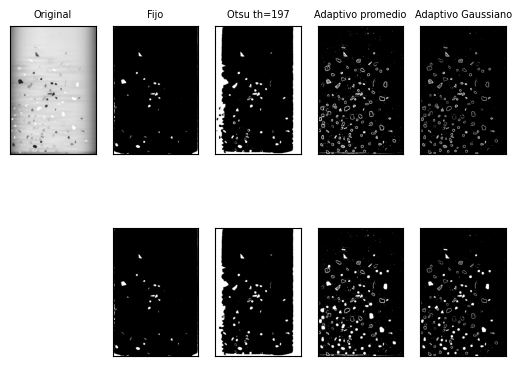

In [16]:
#Carga imagen directamente en grises
imgorig = cv2.imread('MPs_test.jpg', cv2.IMREAD_GRAYSCALE) 

img = cv2.GaussianBlur(imgorig,(5,5),0)

#Umbralizados
ret,imth1 = cv2.threshold(img,150,255,cv2.THRESH_BINARY_INV)
thotsu,imth2 = cv2.threshold(img,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
print('Umbral escogido ', thotsu)
imth3 = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_MEAN_C,\
            cv2.THRESH_BINARY,11,2)
imth4 = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv2.THRESH_BINARY,11,2)
 
titles = ['Original', 'Fijo','Otsu th='+str(int(thotsu)),
            'Adaptivo promedio', 'Adaptivo Gaussiano']
images = [img, imth1, imth2, 255 - imth3, 255 - imth4]
 
for i in range(5):
    plt.subplot(2,5,i+1),plt.imshow(images[i],'gray')
    plt.title(titles[i], fontsize=7)
    plt.xticks([]),plt.yticks([])

    #Obtiene únicamente los contornos externos
    if i>0:
        res,imth = cv2.threshold(images[i],120,255,cv2.THRESH_BINARY)
        contornos, hierarchy= cv2.findContours(imth, 
        cv2.RETR_EXTERNAL , 
        cv2.CHAIN_APPROX_SIMPLE)  
        img_cont = np.zeros(img.shape)
        cv2.drawContours(img_cont, contornos, -1, (255,255,255), -1)  
        plt.subplot(2,5,i+6),plt.imshow(img_cont,'gray')
        plt.xticks([]),plt.yticks([])
plt.show()

Para esta imagen de muestras de microplásticos tenemos una anotación (que puede contener errores) de la tipología de las partículas. Esta será la imagen de test en los experimentos posteriores, no puedes hacer uso de esta imagen para entrenar tu clasificador, solo par evaluarlo

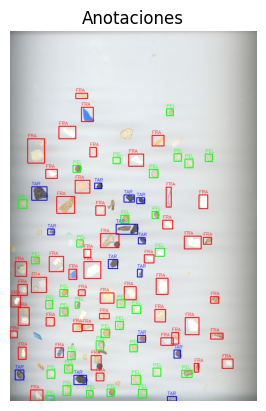

In [102]:
# Imagen y anotaciones
imagen = "MPs_test.jpg"          # Imagen original
csv_file = "MPs_test_bbs.csv"  # CSV con coordenadas y tipología

# Colores de cada clase
colores = {
    "FRA": (0, 0, 255),   # Rojo 
    "PEL": (0, 255, 0),   # Verde
    "TAR": (255, 0, 0)    # Azul
}

# Imagen
img = cv2.imread(imagen)

# Cara csv y dibujar rectángulos
with open(csv_file, newline="") as file:
    reader = csv.DictReader(file)
    for row in reader:
        etiqueta = row["label"]
        x_min, y_min, x_max, y_max = map(int, [row["x_min"], row["y_min"], row["x_max"], row["y_max"]])
        
        # Color según etiqueta
        color = colores.get(etiqueta, (0, 0, 0))  # negro por defecto si no encuentra
        
        # Dibujar rectángulo
        cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color, 2)
        
        # Etiqueta 
        cv2.putText(img, etiqueta, (x_min, y_min - 5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)

# Visualiza resultado
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title("Anotaciones")
plt.axis('off')
plt.show()


##Muestras de entrenamiento

Text(0.5, 1.0, 'Alquitrán')

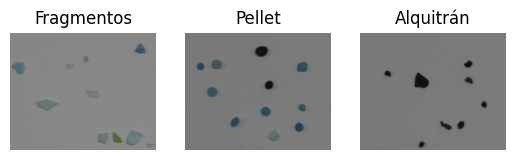

In [16]:
#Cargamos tres subimágenes, por simplicidad, de cada uno de los tres tipos considerados (el alquitrán no es microplástico)
imgF = cv2.imread('FRA.png') 
imgP = cv2.imread('PEL.png') 
imgT = cv2.imread('TAR.png') 

#Mostramos
plt.subplot(131)
plt.axis("off")
plt.imshow(imgF) 
plt.title('Fragmentos')
plt.subplot(132)
plt.axis("off")
plt.imshow(imgP) 
plt.title('Pellet')
plt.subplot(133)
plt.axis("off")
plt.imshow(imgT) 
plt.title('Alquitrán')

El objetivo de la siguiente tarea, descrita más abajo, es desarrollar tu propio clasificador basado únicamente en heurísticas basadas en características geométricas y/o de apariencia, a partir de las imágenes completas de las partículas de cada tipo, debiendo mostrar la bondad del clasificador haciendo uso de métricas para ello sobre las anotaciones de la imagen de test *MPs_test.png*. La siguiente celda obtiene varias métricas para un conjunto de datos imaginario (y con etiquetas aleatorias). Si bien las trataremos con más detalle en teoría, muestro un repertorio de ellas, dando más peso a la matriz de confusión. La ejecución de la celda requiere instalar el paquete scikit-learn.

¿Qué es una matriz de confusión?
Se utiliza para mostrar el comportamiento de un clasificador para las distintas clases conocidas, se relacionan las etiquetas de las muestras anotadas frente a las predichas por el clasificador. Se busca una matriz diagonal, pero la perfección es infrecuente.

El siguiente ejemplo, muestra el modo de obtener la matriz de confusión para un hipotético problema con cuatro clases, y valores de anotación (variable y) y predicción (variable y_pred) obtenidos de forma aleatoria.

Anotaciones  [3, 2, 2, 2, 2, 3, 3, 0, 3, 0, 2, 2, 3, 3, 2, 0, 3, 3, 1, 0, 3, 1, 2, 3, 0, 3, 2, 3, 2, 2, 1, 2, 1, 1, 1, 1, 2, 0, 0, 1, 1, 1, 0, 2, 2, 3, 1, 3, 2, 1, 1, 3, 3, 3, 1, 0, 1, 3, 2, 2, 2, 0, 2, 0, 1, 3, 1, 2, 3, 3, 0, 1, 2, 1, 1, 3, 1, 1, 3, 3, 2, 2, 2, 2, 3, 3, 1, 0, 1, 1, 0, 1, 0, 2, 3, 0, 2, 2, 1, 1]
Predicciones  [1, 2, 2, 3, 0, 0, 3, 3, 2, 0, 0, 2, 2, 1, 1, 0, 3, 3, 3, 0, 2, 3, 3, 3, 0, 2, 0, 1, 3, 1, 3, 1, 3, 2, 2, 0, 0, 3, 3, 1, 3, 3, 0, 3, 3, 1, 0, 3, 3, 2, 0, 1, 1, 2, 1, 1, 1, 3, 1, 1, 0, 3, 0, 3, 0, 0, 3, 1, 1, 0, 3, 1, 0, 2, 3, 1, 0, 0, 0, 0, 1, 0, 1, 2, 2, 3, 0, 1, 1, 0, 3, 1, 3, 1, 2, 0, 1, 1, 1, 2]
¿Cómo de bien encajan anotación y predicción?
Accuracy (TP/(n))= 0.24
Precision (TP/(TP+FP)) = 0.24322796934865903
Recall (TP/(TP+FN)) = 0.24
F1 Score (2*(precision*recall)/(precision+recall)) = 0.23370671834625323


Text(38.25, 0.5, 'Real/Anotado')

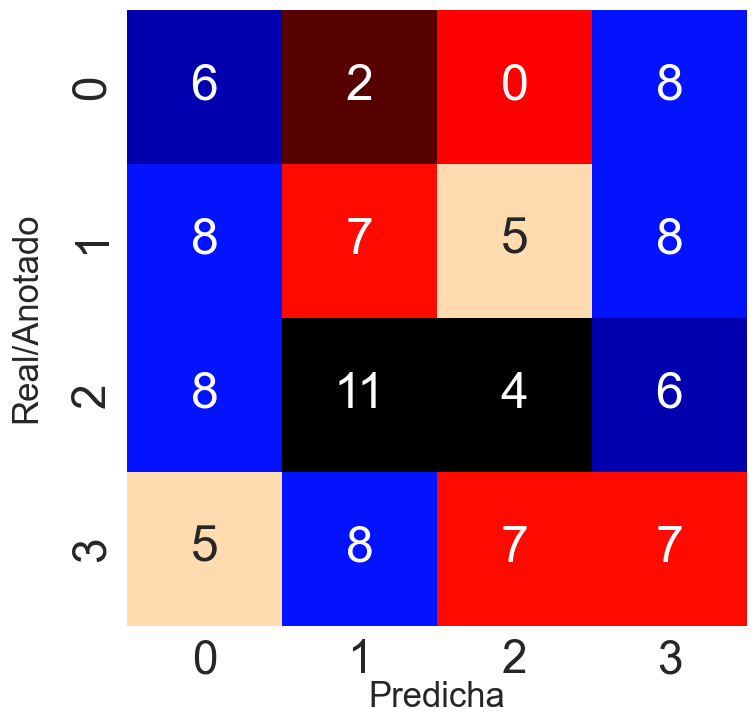

In [18]:

import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)


# Numero de muestras
n = 100  
nclases = 4

# A falta de clasificador y conjunto de datos, creamos anotaciones y predicciones de forma aleatoria
# Vector aleatorio con etiquetas anotadas
y = [random.randint(0, nclases - 1) for _ in range(n)]
print('Anotaciones ' , y)

# Vector aleatorio con etiquetas predichas por un supuesto clasificador
y_pred = [random.randint(0, nclases - 1) for _ in range(n)]
print('Predicciones ' , y_pred)

print('¿Cómo de bien encajan anotación y predicción?')

#Cálculo de métricas
accuracy = accuracy_score(y, y_pred)
#Para más de una clase se define la forma de promediar
precision = precision_score(y, y_pred,average='weighted')
recall = recall_score(y, y_pred,average='weighted')
f1score = f1_score(y, y_pred,average='weighted')

print(f"Accuracy (TP/(n))= {accuracy}")
print(f"Precision (TP/(TP+FP)) = {precision}")
print(f"Recall (TP/(TP+FN)) = {recall}")
print(f"F1 Score (2*(precision*recall)/(precision+recall)) = {f1score}")


conf_matrix = confusion_matrix(y, y_pred)
plt.figure(figsize=(8,8))
sns.set(font_scale = 1.75)#tamaños tipografía
sns.set(font_scale = 3.0)

ax = sns.heatmap(
        conf_matrix, # confusion matrix 2D array 
        annot=True, # Muestra números en las celdas
        fmt='d', # valores enteros
        cbar=False, # sin barra de colores
        cmap='flag', # mapa de colores
        #vmax=175 # contraste de color
    )

#Etiquetas matriz de confusión
label_font = {'size':'25'}
ax.set_xlabel("Predicha", labelpad=-0.75, fontdict=label_font)
ax.set_ylabel("Real/Anotado", labelpad=20, fontdict=label_font)

TAREA: La tarea consiste en extraer características (geométricas y/o visuales) de las tres imágenes completas de partida, y *aprender* patrones que permitan identificar las partículas en nuevas imágenes. Para ello se proporciona como imagen de test *MPs_test.jpg* y sus correpondientes anotaciones *MPs_test_bbs.csv* con la que deben obtener las métricas para su propuesta de clasificación de microplásticos, además de la matriz de confusión. La matriz de confusión permitirá mostrar para cada clase el número de muestras que se clasifican correctamente de dicha clase, y el número de muestras que se clasifican incorrectamente como perteneciente a una de las otras dos clases.

En el trabajo [SMACC: A System for Microplastics Automatic Counting and Classification](https://doi.org/10.1109/ACCESS.2020.2970498), las características geométricas utilizadas fueron:

- Área en píxeles
- Perímetro en píxeles
- Compacidad (relación entre el cuadrado del perímetro y el área de la partícula)
- Relación del área de la partícula con la del contenedor
- Relación del ancho y el alto del contenedor
- Relación entre los ejes de la elipse ajustada
- Definido el centroide, relación entre las distancias menor y mayor al contorno

Si no se quedan satisfechos con la segmentación obtenida, es el mundo real, también en el README comento técnicas recientes de segmentación, que podrían despertar su curiosidad.

In [ ]:
import numpy as np
count = 0
weights = {}
color_mode = 0 # 0: RGB, 1: LAB, 2: HSV

def obtain_contorns(image_path, min_area=5):
    imgorig = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE) 
    img_RGB = cv2.imread(image_path)
    img_RGB = cv2.cvtColor(img_RGB, cv2.COLOR_BGR2RGB)
    img = cv2.GaussianBlur(imgorig,(5,5),0)

    #Umbralizados
    imth_ADP = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_MEAN_C,\
                cv2.THRESH_BINARY,11,2)

    res,imth = cv2.threshold(imth_ADP,120,255,cv2.THRESH_BINARY)
    imth = 255 - imth
    contornos, _ = cv2.findContours(imth, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    contornos_filtrados = [c for c in contornos if cv2.contourArea(c) > min_area]
    
    return img_RGB, contornos_filtrados


def calculate_mean_color(image_path, contornos):
    img = cv2.imread(image_path)
    if color_mode == 0:
        mask = np.zeros(img.shape[:2], dtype=np.uint8)
        for c in contornos:
            cv2.drawContours(mask, [c], -1, 255, -1)
        masked_pixels = img[mask == 255]
        if len(masked_pixels) > 0:
            mean_color = masked_pixels.mean(axis=0)
            std_color  = masked_pixels.std(axis=0)
        else:
            mean_color = np.array([0, 0, 0], dtype=np.float32)
            std_color  = np.array([0, 0, 0], dtype=np.float32)
        return mean_color, std_color
    
    elif color_mode == 1:
        img = cv2.imread(image_path)
        mask = np.zeros(img.shape[:2], dtype=np.uint8)
        for c in contornos:
            cv2.drawContours(mask, [c], -1, (255), -1)
        mean, stddev = cv2.meanStdDev(cv2.cvtColor(img, cv2.COLOR_BGR2LAB), mask=mask)
        return mean.flatten(), stddev.flatten()
    
    else:
        hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        h = hsv[:, :, 0]

        hue_values = []

        for c in contornos:
            mask = np.zeros(img.shape[:2], dtype=np.uint8)
            cv2.drawContours(mask, [c], -1, 255, -1)
            mean_hue, _ = cv2.meanStdDev(h, mask=mask)
            hue_values.append(mean_hue[0][0])

        if hue_values:  # si hay contornos válidos
            mean_hue_all = np.mean(hue_values)
            std_hue_all = np.std(hue_values)
        else:
            mean_hue_all = 0
            std_hue_all = 0

        return mean_hue_all, std_hue_all

    

def get_mean_color_for_contour(img, contorno):
    if color_mode == 0:
        mask = np.zeros(img.shape[:2], dtype=np.uint8)
        cv2.drawContours(mask, [contorno], -1, 255, -1)
        masked_pixels = img[mask == 255]
        if len(masked_pixels) > 0:
            mean_color = masked_pixels.mean(axis=0)
        else:
            mean_color = np.array([0, 0, 0], dtype=np.float32)
        return mean_color

    elif color_mode == 1:
        mask = np.zeros(img.shape[:2], dtype=np.uint8)
        cv2.drawContours(mask, [contorno], -1, (255), -1)
        mean, _ = cv2.meanStdDev(cv2.cvtColor(img, cv2.COLOR_BGR2LAB), mask=mask)
        return mean.flatten()
    else:
        hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        h = hsv[:, :, 0]
        mask = np.zeros(img.shape[:2], dtype=np.uint8)
        cv2.drawContours(mask, [contorno], -1, 255, -1)
        mean_hue, _ = cv2.meanStdDev(h, mask=mask)
        return mean_hue[0][0]

def get_compactness(contorno):
    area = cv2.contourArea(contorno)
    perimeter = cv2.arcLength(contorno, True)
    if perimeter > 0:
        compactness = (perimeter ** 2) / area
    else:
        compactness = -1
    return compactness

def get_aspect_ratio(contorno):
    x, y, w, h = cv2.boundingRect(contorno)
    if h > 0:
        aspect_ratio = w / h
    else:
        aspect_ratio = -1
    return aspect_ratio

def get_ellipse_ratio(contorno):
    if len(contorno) >= 5:
        (center, axes, orientation) = cv2.fitEllipse(contorno)
        major_axis = max(axes)
        minor_axis = min(axes)
        if minor_axis > 0:
            ellipse_ratio = major_axis / minor_axis
        else:
            ellipse_ratio = -1
    else:
        ellipse_ratio = -1
    return ellipse_ratio

def extract_contour_features(contornos):
    compactness_values = []
    aspect_ratios = []
    ellipse_ratios = []
    for c in contornos:
        compactness = get_compactness(c)
        if compactness != -1:
            compactness_values.append(compactness)

        aspect_ratio = get_aspect_ratio(c)
        if aspect_ratio != -1:
            aspect_ratios.append(aspect_ratio)

        ellipse_ratio = get_ellipse_ratio(c)
        if ellipse_ratio != -1:
            ellipse_ratios.append(ellipse_ratio)
    return compactness_values, aspect_ratios, ellipse_ratios

def get_mean_and_stddev(values):
    if values:
        mean_val = np.mean(values)
        stddev_val = np.std(values)
    else:
        mean_val = 0
        stddev_val = 0
    return mean_val, stddev_val

def safe_std(s):
    s = np.array(s)
    s[s < 1e-6] = 1.0
    return s


def get_score(compactness, aspect_ratio, ellipse_ratio, color_mean, model, name=''):
    
    color_score = np.linalg.norm((color_mean - model['mean_color']) / safe_std(model['stddev_color']))
    compactness_score = abs(compactness - model['mean_compactness']) / model['stddev_compactness']
    aspect_ratio_score = abs(aspect_ratio - model['mean_aspect_ratio']) / model['stddev_aspect_ratio']
    ellipse_ratio_score = abs(ellipse_ratio - model['mean_ellipse_ratio']) / model['stddev_ellipse_ratio']
    
    total_score = np.sqrt(
        weights['color']*color_score**2 +
        weights['compactness']*compactness_score**2 +
        weights['aspect']*aspect_ratio_score**2 +
        weights['ellipse']*ellipse_ratio_score**2
    )
    #total_score = color_score + compactness_score + aspect_ratio_score + ellipse_ratio_score
    return total_score

def get_picture_features(img, min_area):
    features = {}
    _, contornos = obtain_contorns(img, min_area)
    mean_color, stddev_color = calculate_mean_color(img, contornos)
    compactness, aspect_ratios, ellipse_ratios = extract_contour_features(contornos)
    mean_compactness, stddev_compactness = get_mean_and_stddev(compactness)
    mean_aspect_ratio, stddev_aspect_ratio = get_mean_and_stddev(aspect_ratios)
    mean_ellipse_ratio, stddev_ellipse_ratio = get_mean_and_stddev(ellipse_ratios)
    features['mean_color'] = mean_color
    features['stddev_color'] = stddev_color
    features['mean_compactness'] = mean_compactness
    features['stddev_compactness'] = stddev_compactness
    features['mean_aspect_ratio'] = mean_aspect_ratio
    features['stddev_aspect_ratio'] = stddev_aspect_ratio
    features['mean_ellipse_ratio'] = mean_ellipse_ratio
    features['stddev_ellipse_ratio'] = stddev_ellipse_ratio
    return features

def classify(contorno, img, models):
    compactness = get_compactness(contorno)
    aspect_ratio = get_aspect_ratio(contorno)
    ellipse_ratio = get_ellipse_ratio(contorno)
    color_mean = get_mean_color_for_contour(img, contorno)
    PEL_score = get_score(compactness, aspect_ratio, ellipse_ratio, color_mean, models['PEL'], name='PEL')
    FRA_score = get_score(compactness, aspect_ratio, ellipse_ratio, color_mean, models['FRA'], name='FRA')
    TAR_score = get_score(compactness, aspect_ratio, ellipse_ratio, color_mean, models['TAR'], name='TAR')
    scores = {'PEL': PEL_score, 'FRA': FRA_score, 'TAR': TAR_score}
    best_class = min(scores, key=scores.get)
    return best_class

PEL = get_picture_features('PEL.png', min_area=25)
FRA = get_picture_features('FRA.png', min_area=50)
TAR = get_picture_features('TAR.png', min_area=50)




PEL 2 0 1 0 1
FRA 0 1 0 0 1
TAR 9 0 2 0 1
PEL 3 0 0 0 0
FRA 1 1 0 0 1
TAR 11 0 0 0 0
PEL 2 0 0 0 0
FRA 1 1 0 0 1
TAR 9 0 1 0 0


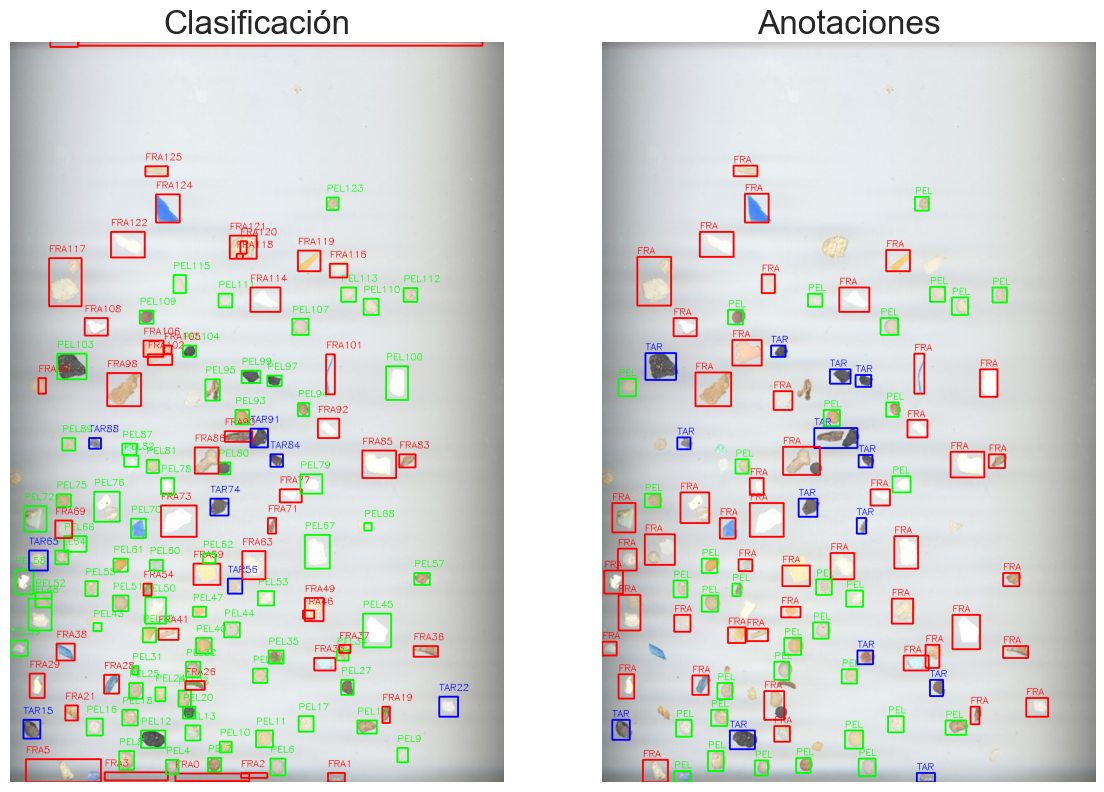

In [264]:
weights = {'color': 0, 'compactness': 1.0, 'aspect': 0.3, 'ellipse': 1.0}
color_mode = 0
test_RGB, test_contornos = obtain_contorns('MPs_test.jpg', min_area=40)
test_RGB_COPY = test_RGB.copy()
global count
for c in test_contornos:
    clase = classify(c, test_RGB, {'PEL': PEL, 'FRA': FRA, 'TAR': TAR})
    x, y, w, h = cv2.boundingRect(c)
    color = (0, 255, 0) if clase == 'PEL' else (255, 0, 0) if clase == 'FRA' else (0, 0, 255)
    cv2.rectangle(test_RGB, (x, y), (x + w, y + h), color, 2)
    cv2.rectangle(test_RGB_COPY, (x, y), (x + w, y + h), color, -1)
    cv2.putText(test_RGB, clase + str(count), (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)
    count += 1
plt.figure(figsize=(14, 14))
plt.subplot(121)
plt.axis("off")
plt.imshow(test_RGB) 
plt.title('Clasificación')

plt.subplot(122)
plt.axis("off")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)) 
plt.title('Anotaciones')

plt.show()


Accuracy = 0.619
Precision = 0.687
Recall = 0.619
F1 Score = 0.612


d:\Anaconda3\envs\VC_P1\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


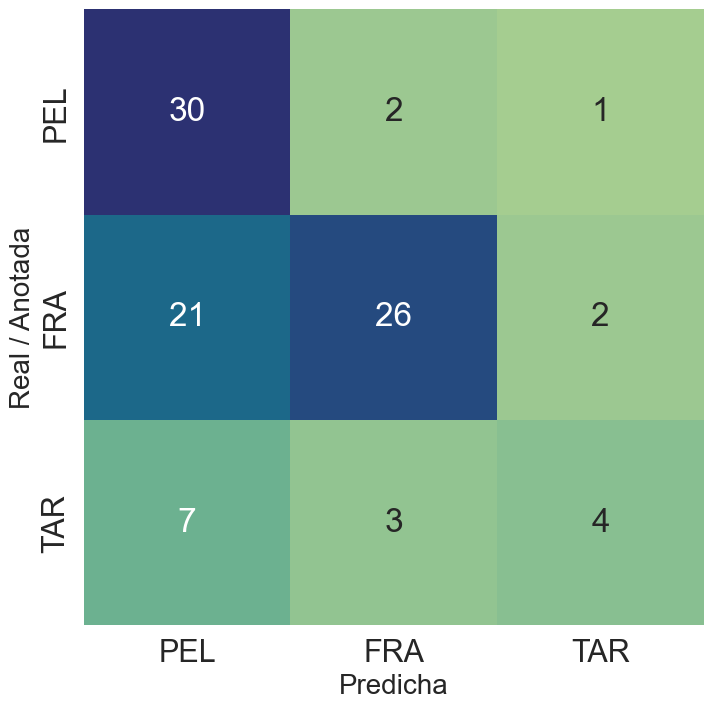

: 

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

y_true = []
y_pred = []

df = pd.read_csv('MPs_test_bbs.csv')
coords_dict = {}
for label, grupo in df.groupby('label'):
    coords = list(zip(grupo['x_min'], grupo['y_min'], grupo['x_max'], grupo['y_max']))
    coords_dict[label] = coords
for label, coords in coords_dict.items():
    for (x_min, y_min, x_max, y_max) in coords:
        cx = int((x_min + x_max) / 2)
        cy = int((y_min + y_max) / 2)
        punto = (cx, cy)
        y_true.append(label)
        if test_RGB_COPY[cy, cx, 1] > 200:
            y_pred.append('PEL')
        elif test_RGB_COPY[cy, cx, 0] > 200:
            y_pred.append('FRA')
        elif test_RGB_COPY[cy, cx, 2] > 200:
            y_pred.append('TAR')
        else:
            y_pred.append('Ninguna')


# Cálculo de métricas
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1score = f1_score(y_true, y_pred, average='weighted')

print(f"Accuracy = {accuracy:.3f}")
print(f"Precision = {precision:.3f}")
print(f"Recall = {recall:.3f}")
print(f"F1 Score = {f1score:.3f}")

# Matriz de confusión
labels = ['PEL', 'FRA', 'TAR']  # ajusta según tus clases reales
conf_matrix = confusion_matrix(y_true, y_pred, labels=labels)

plt.figure(figsize=(8, 8))
sns.set(font_scale=2.0)
ax = sns.heatmap(
    conf_matrix, 
    annot=True, 
    fmt='d', 
    cmap='crest', 
    cbar=False,
    xticklabels=labels, 
    yticklabels=labels
)

ax.set_xlabel("Predicha", fontsize=20)
ax.set_ylabel("Real / Anotada", fontsize=20)
plt.show()


In [10]:
import cv2  
import numpy as np
import matplotlib.pyplot as plt
import csv

# VERSION 2
start = (0, 0)
end = (0, 0)
mouse_pressed = False
COINS_SIZES = {
    0.01: 16.25,
    0.02: 18.75,
    0.10: 19.75,
    0.05: 21.25,
    0.20: 22.25,
    1.00: 23.25,
    0.50: 24.25,
    2.00: 25.75
}
sorted_coins = sorted(COINS_SIZES.items(), key=lambda x: x[1])

perspective_scale_factor = 3.2

# Primer evento del ratón que toma captura de la foto
def mouse_events_camera(event, x, y, flags, params):
    global frame_static, frame_live
    if event == cv2.EVENT_LBUTTONDOWN:
        frame_static = frame_live.copy()

# Segundo evento del ratón que selecciona la moneda y calcula el tamaño de todas las monedas 
def mouse_events_picture(event, x, y, flags, params):
    global start, end, mouse_pressed, captured_image
    if event == cv2.EVENT_LBUTTONDOWN: # Inicio del rectángulo
        start = (x, y)
        mouse_pressed = True
    elif event == cv2.EVENT_LBUTTONUP and mouse_pressed: # Fin del rectángulo
        end = (x, y)
        mouse_pressed = False
        
        # Dibuja el rectángulo final
        img_copy = frame_static.copy()
        cv2.rectangle(img_copy, start, end, (255, 255, 255), 2)
        cv2.imshow("Frame", img_copy)

        # Procesa la moneda seleccionada
        coin = get_coin_size(captured_image, start, end)
        if not coin:
            print("No se ha podido detectar la moneda")
            return
        center, angle, diameter = coin        

        # Calcula todas las monedas de la imagen        
        show_detected_coin_sizes(captured_image, center, angle, diameter)
    elif mouse_pressed:   # Mientras se arrastra el ratón
        end = (x, y)
        img_copy = frame_static.copy()
        cv2.rectangle(img_copy, start, end, (255, 255, 255), -1)
        cv2.imshow("Frame", img_copy)

def get_contours(image, thresh_val = None):
    otsu_threshold_value = None
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Eliminar ruido
    gauss_image = cv2.GaussianBlur(gray, (5, 5), 0)
    blur_image = cv2.medianBlur(gauss_image, 5)
    # aplicar kernel lapaciano
    laplacian = cv2.Laplacian(blur_image, cv2.CV_8U, ksize=5)
    # Dilatar para cerrar huecos
    kernel = np.ones((3, 3), np.uint8)
    blur_image = cv2.dilate(laplacian, kernel, iterations=1)

    # Aplicar umbral OTSU para segmentar automáticamente
    if thresh_val is None:
        print("OTSU")
        otsu_threshold_value, thresh = cv2.threshold(blur_image, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
        cv2.imshow("otsu", thresh)
    else:
        _, thresh = cv2.threshold(blur_image, thresh_val, 255, cv2.THRESH_BINARY_INV)
        print("fijo")
        cv2.imshow("fijo", thresh)
    # Si hay más blanco que negro invertir
    if cv2.countNonZero(thresh) > (thresh.size / 2):
        thresh = cv2.bitwise_not(thresh)
    # Encontrar contornos
    contornos, hierarchy = cv2.findContours(thresh,
        cv2.RETR_EXTERNAL,
        cv2.CHAIN_APPROX_SIMPLE)
    return contornos, otsu_threshold_value 


def calculate_scale(image, angle, reference_diameter, dist):
    alpha = perspective_scale_factor * (image.shape[0] - reference_diameter) / image.shape[0]
    scale = 1 - alpha * ((90-angle) / 90) * (dist / image.shape[0])
    return scale

def estimate_coin_value(diameter_scaled, reference_diameter):
    coin_size = COINS_SIZES[1] * diameter_scaled / reference_diameter
    
    if (coin_size < 13.25):
        return None, None
    if (coin_size > 27.75):
        return None, None

    # Calcular el tamaño de la moneda
    coin_value = 2.00
    prev_value = 0
    # Buscar el valor de la moneda más cercana en tamaño
    for current_value, current_size in sorted_coins:
        if coin_size < current_size:
            if current_size == 16.25:
                coin_value = 0.01
            else:
                prev_size = COINS_SIZES[prev_value] if prev_value else 0
                distance_to_below = abs(coin_size - prev_size)
                distance_to_upper = abs(current_size - coin_size)
                if distance_to_below < distance_to_upper:
                    coin_value = prev_value
                else:
                    coin_value = current_value
            break
        prev_value = current_value
    return (coin_value, coin_size)

def draw_coin_info(image, id, diameter, center, scale, diameter_scaled, coin_value, coin_size):
    cv2.putText(image, f"ID: {id}", (center[0]-30, center[1]-15), 
                            cv2.FONT_HERSHEY_SIMPLEX, font_scale, text_color, thickness, cv2.LINE_8)
    cv2.putText(image, f"Add: {(diameter_scaled-diameter):.2f}", (center[0]-30, center[1]-5), 
                            cv2.FONT_HERSHEY_SIMPLEX, font_scale, text_color, thickness, cv2.LINE_8)
    cv2.putText(image, f"Si: {coin_size:.2f} Sc: {scale:.2}", (center[0]-30, center[1]+5), 
                            cv2.FONT_HERSHEY_SIMPLEX, font_scale, text_color, thickness, cv2.LINE_8)
    cv2.putText(image, f"V: {coin_value:.2f}", (center[0]-30, center[1]+15), 
                            cv2.FONT_HERSHEY_SIMPLEX, font_scale, text_color, thickness, cv2.LINE_8)


def show_detected_coin_sizes(image, position, angle, reference_diameter):
    global font_scale, text_color, thickness
    # Se considera que le diámetro de referencia pertenece a una moneda de un euro
    cantidad_total = 0
    contornos, _ = get_contours(image)
    id = 0
    
    # dibujar circulo principal
    cv2.circle(image, position, int(reference_diameter / 2), (0, 0, 0), 2)
    
    for c in contornos:
        area = cv2.contourArea(c)
        # Si se han encontrado una figura
        if area > 10:
            # Si es suficiente para encajar una elipse
            if c.shape[0] > 5:
                ellipse = cv2.fitEllipse(c)
                (cx, cy), (major_axis, minor_axis), _ = ellipse
                diameter = max(minor_axis, major_axis)
                
                center = (int(cx), int(cy))
                # La distancia solo importa en el eje vertical
                dist = cy - position[1]
                # Calcular la escala usando el angulo por parámetro
                scale = calculate_scale(image, angle, reference_diameter, dist)
                # Ajustar la escala
                diameter_scaled = diameter * scale

                # Filtrar tamaños no válidos
                coin_value, coin_size = estimate_coin_value(diameter_scaled, reference_diameter)
                if not coin_value or not coin_size:
                    continue

                print(f"ID: {id} Moneda: {coin_value}€, Tamaño: {coin_size:.2f}mm, Escala: {scale:.2f}, Distancia: {dist}, diametro escalado: {diameter_scaled}, Diámetro.: {diameter}")
                # Dibuja los contornos de la figura
                cv2.ellipse(image, ellipse, (0, 255, 0), 2)
                # Dibuja el círculo de la moneda escalada
                cv2.circle(image, (int(cx), int(cy)), int(diameter_scaled/2), (255,0,0), 1)
                # Información de la moneda
                draw_coin_info(image, id, diameter, center, scale, diameter_scaled, coin_value, coin_size)
                id += 1
                cantidad_total += coin_value

    cv2.putText(image, f"Total: {cantidad_total:.2f} euros", (10, 50),
                cv2.FONT_HERSHEY_SIMPLEX, font_scale, text_color, thickness, cv2.LINE_8)

def get_coin_size(image, start, end):
    global dibujar_referencia
    coin_image = image.copy()
    
    # Cortamos la imagen a la zona seleccionada
    new_start = (min(start[0], end[0]), min(start[1], end[1]))
    new_end = (max(start[0], end[0]), max(start[1], end[1]))
    coin_image = coin_image[new_start[1]:new_end[1], new_start[0]:new_end[0]]

    _, thresh = get_contours(image) # Obtener el umbral OTSU de la imagen global
    contours, _ = get_contours(coin_image, thresh) # Obtener el contorno de la imagen recortada usando el umbral global
    if contours:
        c_max = max(contours, key=cv2.contourArea)
        # Si el contorno es suficiente para dibujar una elipse, entonces
        if len(c_max) >= 5:
            ellipse = cv2.fitEllipse(c_max)
            (cx, cy), (minor_axis, major_axis), _ = ellipse
            diameter = max(minor_axis, major_axis)

            # Se ajusta el centro a la posición global
            center = (int(cx) + new_start[0], int(cy) + new_start[1])

            # Ángulo artificial, considero que este cálculo da una aproximación del ángulo de inclinación
            stimated_angle = abs(major_axis - minor_axis) / max(major_axis, minor_axis)
            stimated_angle = 90 - stimated_angle * 90

            # Dibuja círculos de referencia de la inclinación
            if dibujar_referencia:
                for i in range(30):
                    dist = 300 - i * 20
                    scale = calculate_scale(image, stimated_angle, diameter, dist)
                    diameter_scaled = diameter * scale
                    new_center = (int(center[0]), int(center[1] - dist))
                    cv2.circle(image, new_center, int(diameter_scaled/2), (255,0,0), 1)

            print(f"Ángulo corregido: {stimated_angle:.2f} grados, Diámetro mayor: {major_axis:.2f}, Diámetro menor: {minor_axis:.2f} píxeles")
            print(f"Centro: {center}, Ángulo: {stimated_angle:.2f} grados, Diámetro mayor: {major_axis:.2f} píxeles")
            print(f"new_start: {new_start}, new_end: {new_end}, window size: {captured_image.shape}")
            return center, stimated_angle, diameter
    else:
        print("No se han encontrado contornos")
        return None


In [35]:
# VERSION 2
vid = cv2.VideoCapture(0)

ret, frame_live = vid.read()
test_image = cv2.imread("camara1.jpg")
cv2.namedWindow("Frame", cv2.WINDOW_NORMAL)
frame_static = None
cv2.imshow("Frame", frame_live)
cv2.setMouseCallback("Frame", mouse_events_camera)

text_color = (0,0,0)
thickness = 1
font_scale = 0.4
dibujar_referencia = False

# Primero esperamos a capturar una imágen
while(True):      
    ret, frame_live = vid.read()
    frame_live = test_image.copy()

    frame_copy = frame_live.copy()
    frame_copy = test_image.copy()
    cv2.putText(frame_copy, f"Click para congelar", (10,30), cv2.FONT_HERSHEY_SIMPLEX, font_scale, text_color, thickness)
    cv2.imshow("Frame", frame_copy)

    if cv2.waitKey(20) == 27 or frame_static is not None:
        # Libera el objeto de captura
        break

if frame_static is None:
    print("No se ha congelado imagen")
    vid.release()
    cv2.destroyAllWindows()

captured_image = frame_static.copy()
cv2.setMouseCallback("Frame", mouse_events_picture)

# Luego esperamos a seleccionar la moneda
while (True):
    frame_static = captured_image.copy()

    cv2.putText(frame_static, f"Selecciona la moneda de 1 euro", (10,30), cv2.FONT_HERSHEY_SIMPLEX, font_scale, text_color, thickness)
    cv2.imshow("Frame", frame_static)

    if cv2.waitKey(20) == 27:
        break

# Libera el objeto de captura
vid.release()
# Destruye ventanas
cv2.destroyAllWindows()

OTSU
fijo
Ángulo corregido: 78.34 grados, Diámetro mayor: 77.92, Diámetro menor: 67.83 píxeles
Centro: (381, 221), Ángulo: 78.34 grados, Diámetro mayor: 77.92 píxeles
new_start: (344, 186), new_end: (419, 258), window size: (683, 800, 3)
OTSU
ID: 0 Moneda: 0.01€, Tamaño: 13.82mm, Escala: 0.76, Distancia: 441.92022705078125, diametro escalado: 46.304812431105816, Diámetro.: 60.741607666015625
ID: 1 Moneda: 0.02€, Tamaño: 18.24mm, Escala: 0.77, Distancia: 433.220947265625, diametro escalado: 61.144536833392245, Diámetro.: 79.71875762939453
ID: 2 Moneda: 0.01€, Tamaño: 14.73mm, Escala: 0.77, Distancia: 422.78411865234375, diametro escalado: 49.38404782374218, Diámetro.: 63.917945861816406
ID: 3 Moneda: 0.02€, Tamaño: 18.98mm, Escala: 0.79, Distancia: 384.57647705078125, diametro escalado: 63.5974421718157, Diámetro.: 80.18182373046875
ID: 4 Moneda: 0.01€, Tamaño: 15.48mm, Escala: 0.84, Distancia: 291.96832275390625, diametro escalado: 51.86464480478066, Diámetro.: 61.52592086791992
ID: 5 